<a href="https://colab.research.google.com/github/aynokt/q-macro/blob/main/project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

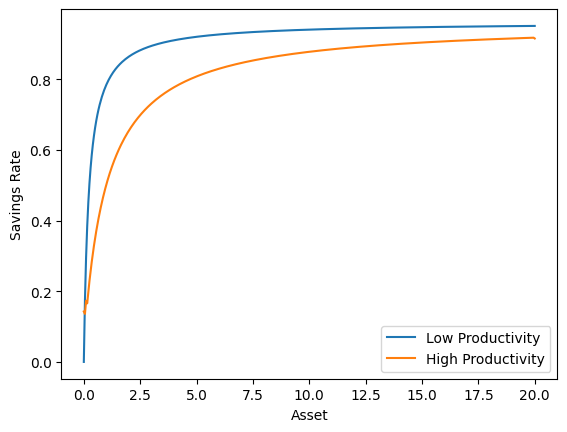

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Tauchen's method
def tauchen(n, mu, rho, sigma):
    m = 1 / np.sqrt(1 - rho**2)
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)
    d = (state_space[n-1] - state_space[0]) / (n-1)
    transition_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if j == 0:
                transition_matrix[i, 0] = norm.cdf((state_space[0] - rho*state_space[i] + d/2) / sigma)
            elif j == n-1:
                transition_matrix[i, n-1] = 1.0 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2) / sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho*state_space[i] + d/2) / sigma) - norm.cdf((state_space[j] - rho*state_space[i] - d/2) / sigma)

    return transition_matrix, state_space

# Set parameters function
def setPar(
    sigma=1.5,  # risk aversion
    beta=0.98,  # subject discount factor
    rho=0.6,  # labor productivity persistence
    sigma_eps=0.6,  # labor productivity std
    a_l=0,  # lower bound of asset grids
    a_u=20,  # upper bound of asset grids
    NA=401,  # number of grids of a
    NH=2,  # number of grids of h
    mu_h=-0.7,  # mean of log h
    alpha=0.25,
    delta=0.03,
):
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)

    param = {
        'sigma': sigma,
        'beta': beta,
        'pi': pi,
        'h': h,
        'NA': NA,
        'NH': NH,
        'a_l': a_l,
        'a_u': a_u,
        'alpha': alpha,
        'delta': delta,
    }

    return param

# Household solution function
def solve_household(param, r, w):
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']

    a = np.linspace(a_l, a_u, NA)
    util = np.full((NA, NA, NH), -10000.0)

    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w*h[ih] + (1.0 + r)*a[ia] - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)

    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)

    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))

    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])

        test = np.max(abs(v_new - v))
        v = v_new

    aplus = a[iaplus]

    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1.0 + r)*a[ia] - aplus[ia, ih]

    return aplus, iaplus, c

# Parameters and initial solution
r = 0.04
w = 1
param = setPar()
decisions = solve_household(param, r, w)
aplus = decisions[0]
c = decisions[2]

# Grids for figures
a_l = param['a_l']
a_u = param['a_u']
NA = param['NA']
a = np.linspace(a_l, a_u, NA)

# Plotting savings rates
plt.plot(a, aplus[:, 0] / (c[:, 0] + aplus[:, 0]), label='Low Productivity')
plt.plot(a, aplus[:, 1] / (c[:, 1] + aplus[:, 1]), label='High Productivity')
plt.xlabel("Asset")
plt.ylabel("Savings Rate")
plt.legend()
plt.show()


In [9]:
def solve_household_tax(param, r, w, tau_k):
    # unpack parameters
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']

    # create a grid of asset holdings
    a = np.linspace(a_l, a_u, NA)

    util = np.full((NA, NA, NH), -10000.0)
    # calculate utility if the agent chooses asset a[iap] for (a[ia]), h[ih])
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w*h[ih] + (1 + (1 - tau_k) * r) * a[ia] - a[iap]
                if cons > 0: # count only if consumption is positive
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)

    # Initialize some variables
    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)

    # iterate on Bellman's equation
    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))

    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])

        test = np.max(abs(v_new - v))
        v = v_new

    # asset policy function
    aplus = a[iaplus]

    # consumption policy function
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1 + (1 - tau_k) * r) * a[ia] - aplus[ia, ih]

    return aplus, iaplus, c


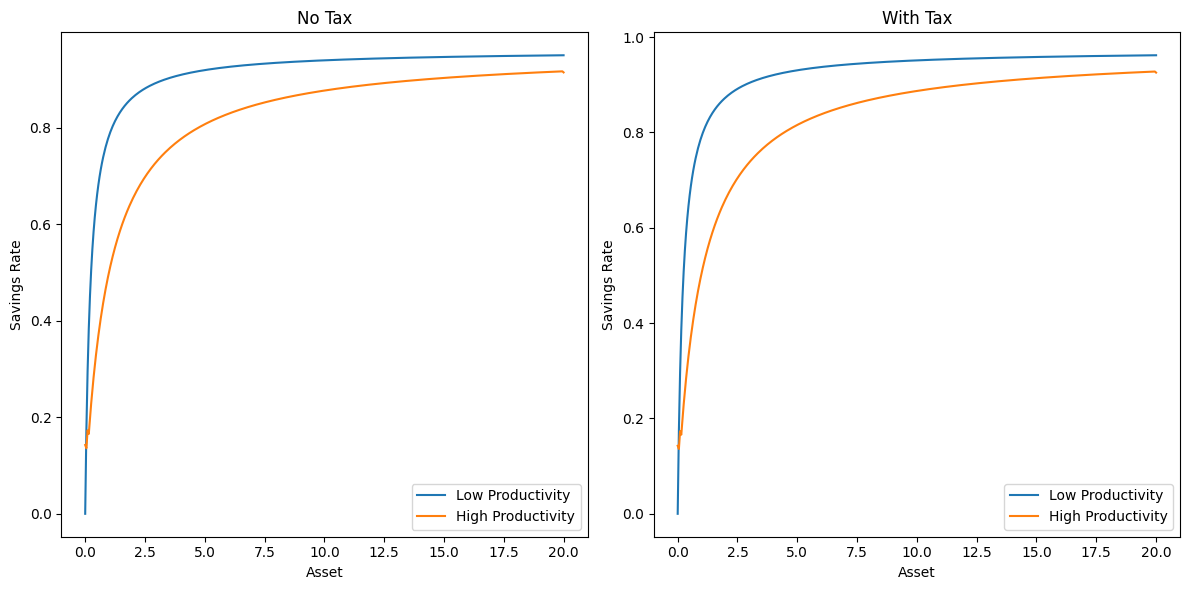

In [10]:
import matplotlib.pyplot as plt

# 設定
r = 0.04
w = 1
tau_k = 0.3  # 資本所得税率

param = setPar()  # パラメータの設定

# 税金導入前の計算
decisions_no_tax = solve_household(param, r, w)
aplus_no_tax = decisions_no_tax[0]
c_no_tax = decisions_no_tax[2]

# 税金導入後の計算
decisions_with_tax = solve_household_tax(param, r, w, tau_k)
aplus_with_tax = decisions_with_tax[0]
c_with_tax = decisions_with_tax[2]

# グリッドの設定
a_l = param['a_l']
a_u = param['a_u']
NA = param['NA']
a = np.linspace(a_l, a_u, NA)

# グラフのプロット
plt.figure(figsize=(12, 6))

# 税金なし
plt.subplot(1, 2, 1)
plt.plot(a, aplus_no_tax[:, 0]/(c_no_tax[:, 0] + aplus_no_tax[:, 0]), label='Low Productivity')
plt.plot(a, aplus_no_tax[:, 1]/(c_no_tax[:, 1] + aplus_no_tax[:, 1]), label='High Productivity')
plt.xlabel("Asset")
plt.ylabel("Savings Rate")
plt.title("No Tax")
plt.legend()

# 税金あり
plt.subplot(1, 2, 2)
plt.plot(a, aplus_with_tax[:, 0]/(c_with_tax[:, 0] + aplus_with_tax[:, 0]), label='Low Productivity')
plt.plot(a, aplus_with_tax[:, 1]/(c_with_tax[:, 1] + aplus_with_tax[:, 1]), label='High Productivity')
plt.xlabel("Asset")
plt.ylabel("Savings Rate")
plt.title("With Tax")
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
def solve_household_subsidy(param, r, w, T):
    # unpack parameters
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']

    # create a grid of asset holdings
    a = np.linspace(a_l, a_u, NA)

    util = np.full((NA, NA, NH), -10000.0)
    # calculate utility if the agent chooses asset a[iap] for (a[ia]), h[ih])
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w*h[ih] + (1 + r) * a[ia] + T - a[iap]
                if cons > 0: # count only if consumption is positive
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)

    # Initialize some variables
    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)

    # iterate on Bellman's equation
    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))

    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])

        test = np.max(abs(v_new - v))
        v = v_new

    # asset policy function
    aplus = a[iaplus]

    # consumption policy function
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1 + r) * a[ia] + T - aplus[ia, ih]

    return aplus, iaplus, c


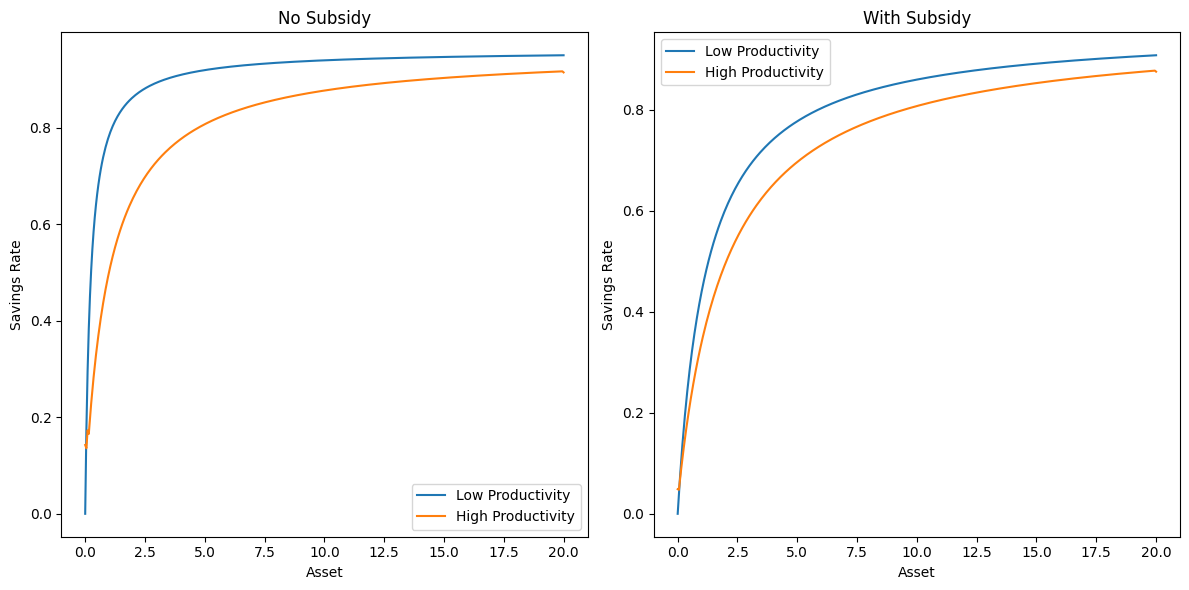

In [12]:
import matplotlib.pyplot as plt

# 設定
r = 0.04
w = 1
T = 1  # 一括補助金

param = setPar()  # パラメータの設定

# 補助金導入前の計算
decisions_no_subsidy = solve_household(param, r, w)
aplus_no_subsidy = decisions_no_subsidy[0]
c_no_subsidy = decisions_no_subsidy[2]

# 補助金導入後の計算
decisions_with_subsidy = solve_household_subsidy(param, r, w, T)
aplus_with_subsidy = decisions_with_subsidy[0]
c_with_subsidy = decisions_with_subsidy[2]

# グリッドの設定
a_l = param['a_l']
a_u = param['a_u']
NA = param['NA']
a = np.linspace(a_l, a_u, NA)

# グラフのプロット
plt.figure(figsize=(12, 6))

# 補助金なし
plt.subplot(1, 2, 1)
plt.plot(a, aplus_no_subsidy[:, 0]/(c_no_subsidy[:, 0] + aplus_no_subsidy[:, 0]), label='Low Productivity')
plt.plot(a, aplus_no_subsidy[:, 1]/(c_no_subsidy[:, 1] + aplus_no_subsidy[:, 1]), label='High Productivity')
plt.xlabel("Asset")
plt.ylabel("Savings Rate")
plt.title("No Subsidy")
plt.legend()

# 補助金あり
plt.subplot(1, 2, 2)
plt.plot(a, aplus_with_subsidy[:, 0]/(c_with_subsidy[:, 0] + aplus_with_subsidy[:, 0]), label='Low Productivity')
plt.plot(a, aplus_with_subsidy[:, 1]/(c_with_subsidy[:, 1] + aplus_with_subsidy[:, 1]), label='High Productivity')
plt.xlabel("Asset")
plt.ylabel("Savings Rate")
plt.title("With Subsidy")
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
def setPar_low_beta(
    sigma=1.5,  # risk aversion
    beta=0.95,  # subject discount factor (lower than before)
    rho=0.6,  # labor productivity persistence
    sigma_eps=0.6,  # labor productivity std
    a_l=0,  # lower bound of asset grids
    a_u=20,  # upper bound of asset grids
    NA=401,  # number of grids of a
    NH=2,  # number of grids of h
    mu_h=-0.7,  # mean of log h
    alpha=0.25,
    delta=0.03,
):
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)

    param = {
        'sigma': sigma,
        'beta': beta,
        'pi': pi,
        'h': h,
        'NA': NA,
        'NH': NH,
        'a_l': a_l,
        'a_u': a_u,
        'alpha': alpha,
        'delta': delta,
    }

    return param


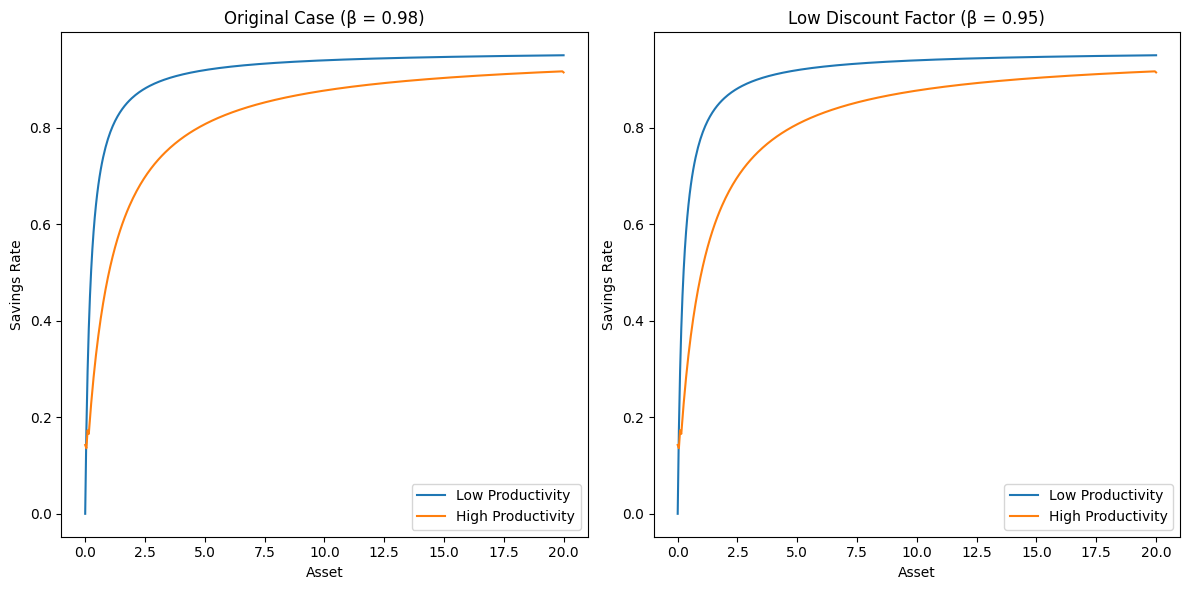

In [14]:
import matplotlib.pyplot as plt

# 設定
r = 0.04
w = 1

# パラメータの設定（元のケース）
param_original = setPar()

# パラメータの設定（低い時間選好率）
param_low_beta = setPar_low_beta()

# オリジナルケースの計算
decisions_original = solve_household(param_original, r, w)
aplus_original = decisions_original[0]
c_original = decisions_original[2]

# 低い時間選好率のケースの計算
decisions_low_beta = solve_household(param_low_beta, r, w)
aplus_low_beta = decisions_low_beta[0]
c_low_beta = decisions_low_beta[2]

# グリッドの設定
a_l = param_original['a_l']
a_u = param_original['a_u']
NA = param_original['NA']
a = np.linspace(a_l, a_u, NA)

# グラフのプロット
plt.figure(figsize=(12, 6))

# オリジナルケース
plt.subplot(1, 2, 1)
plt.plot(a, aplus_original[:, 0]/(c_original[:, 0] + aplus_original[:, 0]), label='Low Productivity')
plt.plot(a, aplus_original[:, 1]/(c_original[:, 1] + aplus_original[:, 1]), label='High Productivity')
plt.xlabel("Asset")
plt.ylabel("Savings Rate")
plt.title("Original Case (β = 0.98)")
plt.legend()

# 低い時間選好率のケース
plt.subplot(1, 2, 2)
plt.plot(a, aplus_low_beta[:, 0]/(c_low_beta[:, 0] + aplus_low_beta[:, 0]), label='Low Productivity')
plt.plot(a, aplus_low_beta[:, 1]/(c_low_beta[:, 1] + aplus_low_beta[:, 1]), label='High Productivity')
plt.xlabel("Asset")
plt.ylabel("Savings Rate")
plt.title("Low Discount Factor (β = 0.95)")
plt.legend()

plt.tight_layout()
plt.show()
